In [3]:
ifo = 'H1'
det_seed_add = ''
for char in ifo:
    det_seed_add += f'{ord(char):03}'
print(int(det_seed_add))

72049


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2
from pycbc.frame import read_frame
from pycbc import psd as psd_func
from pycbc.noise import noise_from_psd
from pycbc.filter import sigma
from simple_pe.waveforms import make_waveform, calculate_mode_snr, two_ecc_harms_SNR

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Zero noise example

In [128]:
# Directory to gwf files
gwf_choice = 1
zero_noise_gwfs = f'MA_datafind_injections/zero_noise_{gwf_choice}/output/'

# Generate psd
ifos = ['H1', 'L1', 'V1']
tlen = 32
sample_rate = 8192
f_low = 20
psds = {'H1': 'aLIGO175MpcT1800545',
        'L1': 'aLIGO175MpcT1800545',
        'V1': 'AdVO3LowT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Read in gwf files as pycbc timeseries
zero_noise_hs = {}
gaussian_noise_hs = {}
seed = 3000
seed_mod = {'H1': 0, 'L1': 1, 'V1': 2}
for ifo in ifos:

    # Read files for zero noise data
    zero_noise_hs[ifo] = read_frame(zero_noise_gwfs+f'{ifo}-INJECTION.gwf', f'{ifo}:HWINJ_INJECTED')
    time_shift = zero_noise_hs[ifo].sample_times[np.argmax(np.array(zero_noise_hs[ifo]))]
    zero_noise_hs[ifo].start_time -= time_shift
    zero_noise_hs[ifo] = zero_noise_hs[ifo].time_slice(-31, 1)

In [141]:
# Generate eccentric harmonics
if gwf_choice == 0:
    harm_pars = {'ecc10sqrd': 0.2**2, 'mass_1': 39.8, 'mass_2': 20, 'spin_1x': 0, 'spin_1y': 0, 'spin_1z': 0.2, 'spin_2x': 0, 'spin_2y': 0, 'spin_2z': 0.1, 'distance': 814}
elif gwf_choice == 1:
    harm_pars = {'ecc10sqrd': 0.3**2, 'mass_1': 60.2, 'mass_2': 40, 'spin_1x': 0, 'spin_1y': 0, 'spin_1z': 0.2, 'spin_2x': 0, 'spin_2y': 0, 'spin_2z': 0.1, 'distance': 814}
    
df = 1/tlen
flen = (tlen*sample_rate)//2 + 1
harms = make_waveform(harm_pars, df, f_low, flen, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6, ecc_harm_psd=psd)

In [142]:
# Get SNR in each mode
zero_sigmas = {}
zero_rhos = {}
for ifo in ifos:
    zero_sigmas[ifo] = sigma(zero_noise_hs[ifo], psd=psd[ifo], low_frequency_cutoff=f_low)
    zero_rhos[ifo], _ = calculate_mode_snr(zero_noise_hs[ifo], psd[ifo], harms[ifo], zero_noise_hs[ifo].sample_times[0],
                                           zero_noise_hs[ifo].sample_times[-1], f_low, harms[ifo].keys(), dominant_mode=0, subsample_interpolation=False)

# Print SNRs
for ifo in ifos:
    print(f'{ifo}: {zero_sigmas[ifo]:.2f}')
    total_sq = 0
    for key in zero_rhos[ifo].keys():
        print(f'  rho_{key}: {np.abs(zero_rhos[ifo][key]):.2f}, phi_{key}: {np.angle(zero_rhos[ifo][key]):.2f}')
        total_sq += np.abs(zero_rhos[ifo][key])**2
    print(f'    total: {np.sqrt(total_sq):.2f}')

H1: 30.05
  rho_0: 28.68, phi_0: -2.40
  rho_1: 6.11, phi_1: -2.22
  rho_-1: 4.29, phi_-1: -2.64
  rho_2: 3.53, phi_2: -1.87
    total: 29.85
L1: 37.82
  rho_0: 36.10, phi_0: 1.03
  rho_1: 7.69, phi_1: 1.21
  rho_-1: 5.39, phi_-1: 0.76
  rho_2: 4.43, phi_2: 1.56
    total: 37.56
V1: 10.03
  rho_0: 9.87, phi_0: 2.66
  rho_1: 1.11, phi_1: 2.98
  rho_-1: 0.77, phi_-1: 2.84
  rho_2: 0.73, phi_2: -2.85
    total: 9.99


## SNR-weighted average

First approach is to average the MA in each detector by weighting by the SNR^2 in each detector.

In [143]:
# Measure MA in each detector
esnrs = {}
mas = {}
for ifo in ifos:
    esnr, ma = two_ecc_harms_SNR({key: np.abs(zero_rhos[ifo][key]) for key in [0,1,-1]},
                                 {key: np.angle(zero_rhos[ifo][key]) for key in [0,1,-1]})
    esnrs[ifo] = esnr*np.abs(zero_rhos[ifo][0])
    mas[ifo] = ma
    print(f'{ifo} esnr: {esnrs[ifo]:.2f}, MA: {mas[ifo]:.2f}')

H1 esnr: 7.46, MA: 0.20
L1 esnr: 9.38, MA: 0.21
V1 esnr: 1.32, MA: 0.16


We will use the following equation:

$$
{\rho^\prime}^2 e^{i\phi^\prime} = \sum_j \rho_j^2 e^{i\phi_j}
$$

This also gives us the total eccentric SNR, which is slightly reduced due to enforcing this MA consistency.

In [144]:
def snr_weight_avg(esnrs, mas):
    ecc_snr_cplx = np.sum([esnrs[ifo]**2*np.exp(1j*mas[ifo]) for ifo in ifos])
    return np.sqrt(np.abs(ecc_snr_cplx)), np.angle(ecc_snr_cplx)

snr_weight_avg(esnrs, mas)

(12.056050756477553, 0.20584888333596477)

## Sum across detectors

An alternative approach would be to sum each harmonic snr across detectors then simply read off the MA as a single value. The code to do this first step is already in place in simple-pe but does not return the snr as complex so I have edited the function below. 

This works with the following equation:

$$
\rho_k^\prime e^{i\phi_k^\prime} = \sum_j \rho_{j,0} \rho_{j,k} e^{i \left(\phi_{j,k} - \phi_{j,0}\right)} / \sqrt{\sum_j \rho_{j,0}^2}
$$

This not only enforce phase consistency but also amplitude consistency with the dominant mode.

We can then simply calculate the eccentric SNR and mean anomaly from the harmonic network snrs.

In [145]:
def network_mode_snr_cplx(z, ifos, modes, dominant_mode='22'):
    """
    Calculate the Network SNR in each of the specified modes.  For the
    dominant mode, this is simply the root sum square of the snrs in each
    ifo.  For the other modes, we calculate both the rss SNR and the network
    SNR which requires the relative phase between ifos is consistent with
    the dominant.

    Parameters
    ----------
    z: dict
        dictionary of dictionaries of SNRs in each mode (in each ifo)
    ifos: list
        A list of ifos to use
    modes: list
        A list of modes to use
    dominant_mode: str
        the mode with most power (for orthogonalization)

    Returns
    -------
    rss_snr: dict
        the root sum squared SNR in each mode
    net_snr: dict
        the SNR in each mode that is consistent (in amplitude and
        phase) with the dominant mode SNR
    """

    z_array = {}

    rss_snr = {}

    for mode in modes:
        z_array[mode] = np.array([z[ifo][mode] for ifo in ifos])
        rss_snr[mode] = np.linalg.norm(z_array[mode], axis=0)

    net_snr = {}

    for mode in modes:
        net_snr[mode] = np.sum(z_array[mode]*z_array[dominant_mode].conjugate(), axis=0) / rss_snr[dominant_mode]

    return rss_snr, net_snr

In [146]:
rss_snr, net_snr = network_mode_snr_cplx(zero_rhos, ifos, harms['H1'].keys(), dominant_mode=0)
esnr, ma = two_ecc_harms_SNR({key: np.abs(net_snr[key]) for key in [0,1,-1]},
                             {key: np.angle(net_snr[key]) for key in [0,1,-1]})
esnr *= np.abs(net_snr[0])

print(esnr, ma)

11.993860275220758 0.2052092377669951


We see here a slight difference - the amplitude is slightly lower for example. I believe this to be more accurate as it is enforcing amplitude and phase consistency on $z_1$ and $z_{-1}$ across detectors, whereas the other approach only enforced phase consistency on the measured values of MA in each detector.

# Gaussian noise

In order to test that this approach is resilient against noise, we can try many samples of noise realisations and check that the measured eccentric snr and ma follow the expected distributions.

In [147]:
# Generate snr samples
n = 10**6
gaussian_samples = {}
for ifo in ifos:
    gaussian_samples[ifo] = {}
    for key in harms['H1'].keys():
        gaussian_samples[ifo][key] = zero_rhos[ifo][key] + np.random.normal(size=n) + 1j*np.random.normal(size=n)

# Calculate network snr samples and eccentric snr
rss_samples, net_snr_samples = network_mode_snr_cplx(gaussian_samples, ifos, harms['H1'].keys(), dominant_mode=0)
esnr_samples, ma_samples = two_ecc_harms_SNR({key: np.abs(net_snr_samples[key]) for key in [0,1,-1]},
                                             {key: np.angle(net_snr_samples[key]) for key in [0,1,-1]})
esnr_samples *= np.abs(net_snr_samples[0])

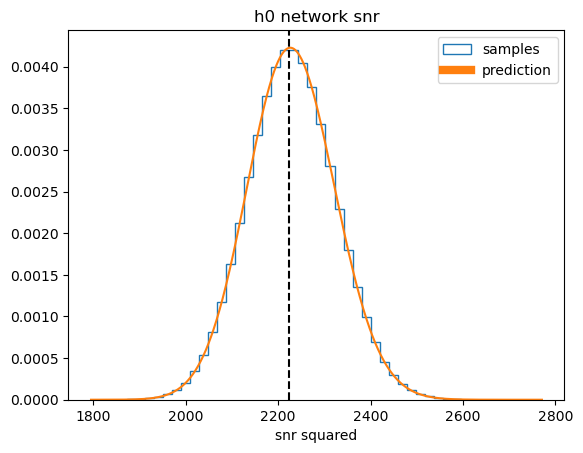

In [148]:
# Dominant harmonic network snr has 6 dof [2*n_det]
_ = plt.hist(np.abs(net_snr_samples[0])**2, bins=50, histtype='step', density=True, label='samples')
snrs = np.linspace(np.min(net_snr_samples[0]), np.max(net_snr_samples[0]), 1000)
pdfs = ncx2.pdf(snrs**2, 2*len(ifos), net_snr[0]**2)
plt.plot(snrs**2, pdfs, label='prediction')
plt.axvline(net_snr[0]**2, c='k', ls='dashed')
plt.xlabel('snr squared')
plt.title('h0 network snr')
plt.legend()
plt.show()

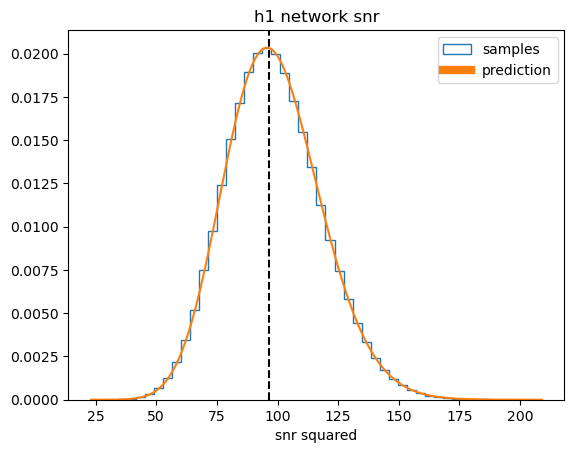

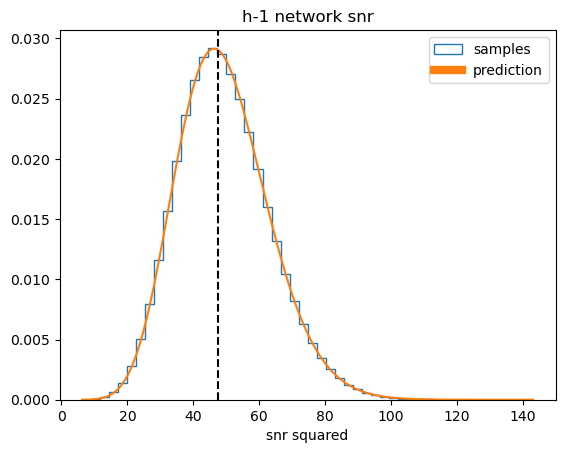

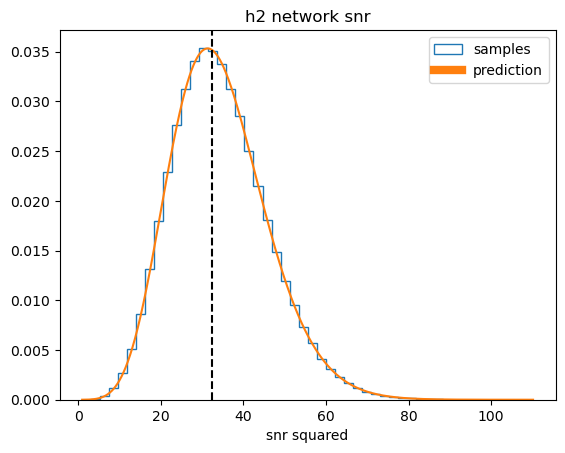

In [149]:
# Subdominant harmonic network snrs have 2 dof
for key in [1, -1, 2]:
    _ = plt.hist(np.abs(net_snr_samples[key])**2, bins=50, histtype='step', density=True, label='samples')
    snrs = np.linspace(np.min(np.abs(net_snr_samples[key])), np.max(np.abs(net_snr_samples[key])), 1000)
    pdfs = ncx2.pdf(snrs**2, 2, np.abs(net_snr[key])**2)
    plt.plot(snrs**2, pdfs, label='prediction')
    plt.axvline(np.abs(net_snr[key])**2, c='k', ls='dashed')
    plt.xlabel('snr squared')
    plt.title(f'h{key} network snr')
    plt.legend()
    plt.show()

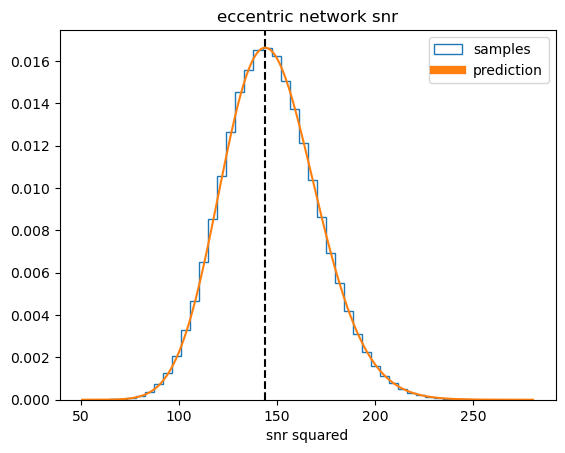

In [150]:
# Eccentric network snrs has 3 dof
_ = plt.hist(np.abs(esnr_samples)**2, bins=50, histtype='step', density=True, label='samples')
snrs = np.linspace(np.min(np.abs(esnr_samples)), np.max(np.abs(esnr_samples)), 1000)
pdfs = ncx2.pdf(snrs**2, 3, np.abs(esnr)**2)
plt.plot(snrs**2, pdfs, label='prediction')
plt.axvline(np.abs(esnr)**2, c='k', ls='dashed')
plt.xlabel('snr squared')
plt.title('eccentric network snr')
plt.legend()
plt.show()

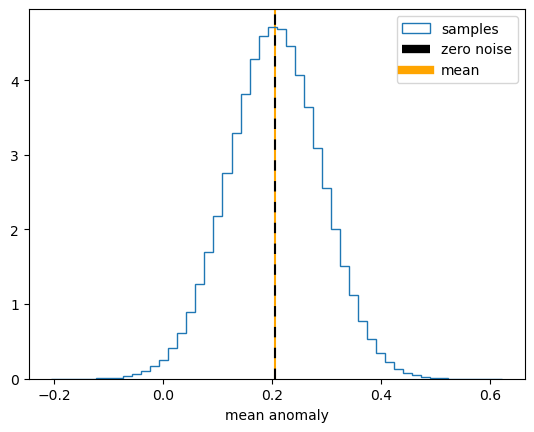

In [151]:
# Eccentric network snrs has 3 dof
_ = plt.hist((ma_samples+np.pi)%(2*np.pi)-np.pi, bins=50, histtype='step', density=True, label='samples')
plt.axvline((ma+np.pi)%(2*np.pi)-np.pi, c='k', ls='dashed', dashes=(5, 5), label='zero noise')
mean_ma = np.mean((ma_samples+np.pi)%(2*np.pi)-np.pi)
plt.axvline((mean_ma+np.pi)%(2*np.pi)-np.pi, c='orange', zorder=1, label='mean',)
plt.xlabel('mean anomaly')
plt.legend()
plt.show()